# Sentiment Analysis pada Ulasan Redenominasi Rupiah RI, 2026

Redenominasi adalah proses penyederhanaan nilai nominal mata uang dengan menghilangkan beberapa angka nol dari nominal tanpa menghilangkan nilai aslinya/daya belinya. Jadi, meskipun nominal berubah, nilai uang tetap sama. Misalnya dari yang awalnya Rp 100.000, setelah redenominasi menjadi Rp 100 (dikurangi 3 nol) dan daya belinya tetap sama. <br>

Baru-baru saja MenKeu RI, Purbaya Sadhewa mengumumkan adanya rencana redenominasi rupiah dengan tujuan menyederhanakan sistem transaksi dan pembukuan keuangan. Selain itu, juga menumbuhkan rasa percaya dari investor asing. Rencana ini mendapat berbagai bentuk sentiment dari masyarakat. Ada yang langsung menunjukkan respon positif namun ada juga yang menolak. <br>

Salah satu YouTuber terkenal Indonesia, Raymond Chin, mengulas terkait rancangan ini di kanal YouTubenya. Video yang diunggah pada Selasa, 11 November 2025 itu langsung mendapatkan berbagai sentiment dari masyarakat Indonesia. <br>

Projek sentiment analysis ini bertujuan untuk mengetahui seberapa besar presentase perbandingan sentiment masyarakat terhadap rencana redenominasi rupiah RI. Melalui proyek ini, kita bisa tahu apakah masyarakat cenderung menerima atau justru menolak kebijakan tersebut.

## Import Library

In [56]:
# KEBUTUHAN UMUM
import pandas as pd
import numpy as np
import pickle

# KEBUTUHAN PREPROCESSING TEKS
import re
import string
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
from nltk.tokenize import  word_tokenize
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# KEBUTUHAN LABELING
import csv
import requests
from io import StringIO

# KEBUTUHAN VISUALISASI DAN EKSPLORASI LABEL
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import  WordCloud

# KEBUTUUHAN FITUR EXTRACTION DAN MODELLING
from sklearn.model_selection import cross_val_score, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import  LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from xgboost import  XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# COZY CODING
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Exploratory Data Analysis

In [89]:
df = pd.read_csv('redenominasi.csv')
df.head()

,Unnamed: 0,publisedAt,username,commentDisplay
0,0,2025-11-12T04:57:26Z,@rbeberumahbelajarbersama5746,"Izin kak Raymond, tahun 1965 menurut data yang..."
1,1,2025-11-12T04:56:15Z,@muhammadakbarw1288,"Wah kadang gua suka kelebihan 0 lagi 😂, mudah&..."
2,2,2025-11-12T04:56:08Z,@iPhoneX-j9s,Rasa hmpir smua org kok.. Ngmong.. Eh lu beli ...
3,3,2025-11-12T04:54:30Z,@Gaffialfatih,"Dari Bennix trus kesini dulu, sebelum komen ma..."
4,4,2025-11-12T04:53:57Z,@DrBethanyHughes,"Sekilas keliatan biasa, tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda."


In [90]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Unnamed: 0      1328 non-null   int64 
 1   publisedAt      1328 non-null   object
 2   username        1328 non-null   object
 3   commentDisplay  1328 non-null   object
dtypes: int64(1), object(3)
memory usage: 41.6+ KB


In [91]:
# Cek dimensi data
df.shape

(1328, 4)

In [92]:
# cek missing value
df.isnull().sum()

Unnamed: 0        0
publisedAt        0
username          0
commentDisplay    0
dtype: int64

In [93]:
# cek duplikat
df.duplicated().sum()

np.int64(0)

**Penjelasan :**
Data bersih dari missing value dan duplikat. Selanjutnya pilih feature yang akan digunakan: <br>

1. publishedAt
2. username
3. commentDisplay

In [94]:
df = df.drop(columns=['Unnamed: 0'])
df.head()

,publisedAt,username,commentDisplay
0,2025-11-12T04:57:26Z,@rbeberumahbelajarbersama5746,"Izin kak Raymond, tahun 1965 menurut data yang..."
1,2025-11-12T04:56:15Z,@muhammadakbarw1288,"Wah kadang gua suka kelebihan 0 lagi 😂, mudah&..."
2,2025-11-12T04:56:08Z,@iPhoneX-j9s,Rasa hmpir smua org kok.. Ngmong.. Eh lu beli ...
3,2025-11-12T04:54:30Z,@Gaffialfatih,"Dari Bennix trus kesini dulu, sebelum komen ma..."
4,2025-11-12T04:53:57Z,@DrBethanyHughes,"Sekilas keliatan biasa, tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda."


## Preprocessing Text

### Cleaning Text

In [95]:
# FUNGSI CLEANING TEXT
def cleaningText(text):
    text = re.sub(r'@[A-Za-z0-9]+', '', text) #hapus mention
    text = re.sub(r'#[A-Za-z0-9]+', '', text) #hapus hashtag
    text = re.sub(r'RT[\s]', '', text) #hapus RT
    text = re.sub(r'RW[\s]', '', text) #hapus RW
    text = re.sub(r"http\S+", '', text) #hapus link
    text = re.sub(r'[0-9]+', '', text) #hapus angka
    text = re.sub(r'[^\w\s]', '', text) #hapus karakter selain huruf dan angka
    text = text.replace('\n', ' ') #ganti baris baru dengan spasi
    text = text.translate(str.maketrans('', '', string.punctuation)) #hapus semua tanda baca
    text = text.strip(' ') #hapus karakter spasi dari kiri dan kanan teks
    return text

# FUNGSI CASE FOLDING
def caseFolding(text):
    text = text.lower()
    return text

# FUNGSI HANDLING SLANK
slangwords = {"@": "di", "abis": "habis", "wtb": "beli", "masi": "masih", "wts": "jual", "wtt": "tukar", "bgt": "banget", "maks": "maksimal", "d": "di", "gak": "tidak", "medsos": "media sosial", "pd": "pada", "ga": "tidak", "mslh": "masalah", "santuy": "santai", "trus": "terus", "yg": "yang", "oke": "baik", "kasi": "kasih", "gw": "saya", "wapres": "wakil presiden", "kepingin": "ingin", "auto": "otomatis", "utk": "untuk", "bbrp" : "beberapa", "dri": "dari", "org2": "orang-orang", "ancur": "hancur", "spt": "seperti", "bgt": "banget", "btw": "ngomong-ngomong", "anjir": "kaget", "anjay": "takjub","busyeet": "busyet","dach": "deh","ga": "tidak","gak": "tidak","gpp": "tidak apa-apa","gw": "saya","loe": "kamu","lu": "kamu","maen": "main","nggak": "tidak","ngga": "tidak","nyimak": "menyimak","sumpah": "serius","wkwk": "tertawa","wk": "tertawa","yoi": "iya","dgn": "dengan","sampe": "sampai","tdk": "tidak","kalo": "kalau","om": "paman","loh": "ekspresi heran","yaaa": "ya","org": "orang",}
def fix_slangwords(text):
    words = text.split()
    fixed_words = []

    for word in words:
        if word.lower() in slangwords:
            fixed_words.append(slangwords[word.lower()])
        else:
            fixed_words.append(word)

    fixed_text = ' '.join(fixed_words)
    return fixed_text

# FUNGSI TOKENISASI
def tokenizingText(text):
    text = word_tokenize(text)
    return  text

# STOPWORDS HANDLING
def stopwordsText(text):
    listStopwords = set(stopwords.words('indonesian'))
    listStopwords1 = set(stopwords.words('english'))
    listStopwords.update(listStopwords1)
    listStopwords.update(['iya','yaa','gak','nya','na','sih','ku',"di","ga","ya","gaa","loh","kah","woi","woii","woy", 'gk', 'cuy', 'dih', 'beuh', 'eee', 'heee', 'nih', 'nihh', 'dong', 'mulu', 'mah', ])
    filtered = []
    for txt in text:
        if txt not in listStopwords:
            filtered.append(txt)
    text = filtered
    return text

# FUNGSI STEMMING TEKS
def stemmingText(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()

    #Stemming setiap kata
    stemmed_words = [stemmer.stem(word) for word in text]

    #Gabung kata yang telah distem dengan spasi
    stemmed_text = ' '.join(stemmed_words)

    return stemmed_text

# SIMPAN NASKAH AKHIR
def toSentence(list_words):
    sentence = ' '.join(word for word in list_words)
    return sentence

In [96]:
 # IMPLEMENTASI FUNGSI
# Bersihkan teks dg regex
df['text_clean'] = df['commentDisplay'].apply(cleaningText)

# Case folding
df['text_caseFolding'] = df['text_clean'].apply(caseFolding)

# Slang Handling
df['text_slangWords'] = df['text_caseFolding'].apply(fix_slangwords)

# Tokenisasi
df['text_tokenizing'] = df['text_slangWords'].apply(tokenizingText)

# Stopwords Handling
df['text_stopwords'] = df['text_tokenizing'].apply(stopwordsText)

# Join text
df['text_final'] = df['text_stopwords'].apply(toSentence)

df.head()

,publisedAt,username,commentDisplay,text_clean,text_caseFolding,text_slangWords,text_tokenizing,text_stopwords,text_final
0,2025-11-12T04:57:26Z,@rbeberumahbelajarbersama5746,"Izin kak Raymond, tahun 1965 menurut data yang...",Izin kak Raymond tahun menurut data yang ada ...,izin kak raymond tahun menurut data yang ada ...,izin kak raymond tahun menurut data yang ada b...,"[izin, kak, raymond, tahun, menurut, data, yan...","[izin, kak, raymond, data, redenominasi, saner...",izin kak raymond data redenominasi sanering
1,2025-11-12T04:56:15Z,@muhammadakbarw1288,"Wah kadang gua suka kelebihan 0 lagi 😂, mudah&...",Wah kadang gua suka kelebihan lagi mudahquot...,wah kadang gua suka kelebihan lagi mudahquot...,wah kadang gua suka kelebihan lagi mudahquotan...,"[wah, kadang, gua, suka, kelebihan, lagi, muda...","[kadang, gua, suka, kelebihan, mudahquotan, sa...",kadang gua suka kelebihan mudahquotan salah kirim
2,2025-11-12T04:56:08Z,@iPhoneX-j9s,Rasa hmpir smua org kok.. Ngmong.. Eh lu beli ...,Rasa hmpir smua org kok Ngmong Eh lu beli baju...,rasa hmpir smua org kok ngmong eh lu beli baju...,rasa hmpir smua orang kok ngmong eh kamu beli ...,"[rasa, hmpir, smua, orang, kok, ngmong, eh, ka...","[hmpir, smua, orang, ngmong, eh, beli, baju, b...",hmpir smua orang ngmong eh beli baju brp pdhl ...
3,2025-11-12T04:54:30Z,@Gaffialfatih,"Dari Bennix trus kesini dulu, sebelum komen ma...",Dari Bennix trus kesini dulu sebelum komen mac...,dari bennix trus kesini dulu sebelum komen mac...,dari bennix terus kesini dulu sebelum komen ma...,"[dari, bennix, terus, kesini, dulu, sebelum, k...","[bennix, kesini, komen, macem, informasi, beri...",bennix kesini komen macem informasi berimbang ...
4,2025-11-12T04:53:57Z,@DrBethanyHughes,"Sekilas keliatan biasa, tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda.",Sekilas keliatan biasa tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda,sekilas keliatan biasa tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda,sekilas keliatan biasa tapi 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda,"[sekilas, keliatan, biasa, tapi, 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕, tuh...","[sekilas, keliatan, 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕, tuh, beda]",sekilas keliatan 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda


In [97]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   publisedAt        1328 non-null   object
 1   username          1328 non-null   object
 2   commentDisplay    1328 non-null   object
 3   text_clean        1328 non-null   object
 4   text_caseFolding  1328 non-null   object
 5   text_slangWords   1328 non-null   object
 6   text_tokenizing   1328 non-null   object
 7   text_stopwords    1328 non-null   object
 8   text_final        1328 non-null   object
dtypes: object(9)
memory usage: 93.5+ KB


### Labelling Text (Polarisasi)

In [126]:
positive = {
    'baik', 'bagus', 'lancar', 'menyederhanakan', 'sederhana', 'jelas', 'mudah', 'dukung', 'teliti', 'investasi', 'berhasil', 'cepat', 'bermanfaat', 'berguna', 'setuju', 'matang', 'menguntungkan', 'trust', 'optimis', 'gampang', 'positif', 'terima', 'kasih', 'sosialisasi', 'dukung', 'paham', 'mengerti', 'bangkit', 'emas', 'efisien', 'efektif', 'tinggi', 'invest', 'menstimulus', 'stimulus', 'menguat', 'sukses', 'semangat', 'bermartabat', 'cerdas', 'pinter', 'terealisasi', 'pemberantasan', 'media', 'sosial', 'setuju', 'sekali', 'percaya', 'nyaman', 'maju', 'mantap', 'edukasi', 'semoga', 'tunggu', 'aman', 'perbaiki', 'super', 'menyenangkan', 'good', 'luck'
}

negative = {
    'tidak', 'gagal', 'pesimis', 'sulit', 'susah', 'miskin', 'berisiko', 'parah', 'bodoh', 'rendah', 'lemah', 'palsu', 'serakah', 'negatif', 'bohong', 'egois', 'koruptor', 'korupsi', 'becus', 'muak', 'jangan', 'inflasi', 'resiko', 'tolak', 'blunder', 'bingung', 'bobrok', 'jahat', 'morat', 'marit', 'membagongkan', 'buang', 'aneh', 'bernilai', 'tamak', 'sembrono', 'korup', 'korupsi', 'misleading', 'males', 'kacung', 'terganggu', 'ganggu', 'keras', 'takut', 'mumet', 'payah', 'dikit', 'ancaman', 'sanering', 'ketakutan', 'takut', 'salah', 'tikus', 'nakutin', 'murahan', 'utang', 'dikit', 'bodo', 'hancur', 'receh', 'gimana', 'ketinggalan'
}

# Fungsi klasifikasi sentiment (0 = negatif, 1 = netral, 2 = positif)
def classify_sentiment(texts):
    texts = texts.lower()

    if any(kata in texts for kata in positive):
        return 2
    elif any(kata in texts for kata in negative):
        return  0
    else:
        return 1

df['Sentiment'] = df['text_final'].apply(classify_sentiment)
print("Distribusi label: ", np.bincount(df['Sentiment']))
df[['text_final', 'Sentiment']].head().style.hide(axis='index')

Distribusi label:  [290 456 582]


text_final,Sentiment
izin kak raymond data redenominasi sanering,0
kadang gua suka kelebihan mudahquotan salah kirim,2
hmpir smua orang ngmong eh beli baju brp pdhl rbatw kmarin beli topi brp pghal rbmalah dtmpt sy udh ngmong jt sribu,1
bennix kesini komen macem informasi berimbang njelasin orang tinggal wait see ajaterimakasih raymond,2
sekilas keliatan 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda,1


In [127]:
print(df['Sentiment'].value_counts())

Sentiment
2    582
1    456
0    290
Name: count, dtype: int64


In [128]:
# Ubah hasil polarisasi ke kata
sentiment_mapp = {
    0 : 'Negative',
    1 : 'Neutral',
    2 : 'Positive'
}

df['Sentiment_Label'] = df['Sentiment'].map(sentiment_mapp)
df[['text_final', 'Sentiment', 'Sentiment_Label']].head(10)

,text_final,Sentiment,Sentiment_Label
0,izin kak raymond data redenominasi sanering,0,Negative
1,kadang gua suka kelebihan mudahquotan salah kirim,2,Positive
2,hmpir smua orang ngmong eh beli baju brp pdhl ...,1,Neutral
3,bennix kesini komen macem informasi berimbang ...,2,Positive
4,sekilas keliatan 𝘗𝘜𝘓𝘈𝘜𝘞𝘐𝘕 tuh beda,1,Neutral
5,𝗣𝗨𝗟𝗔𝗨𝗪𝗜𝗡 jawabannya,1,Neutral
6,setuju redenominasi jegalan koruptor amati dir...,2,Positive
7,stay real stay tulus stay 𝓟𝓤𝓛𝓐𝓤𝓦𝓘𝓝,1,Neutral
8,skeptis betah dipulauwin,1,Neutral
9,koropsi duwitya bangker ketar ketir ni pejabat...,1,Neutral


In [146]:
# SIMPAN HASIL
df.to_csv('redenominasi_polarited.csv')

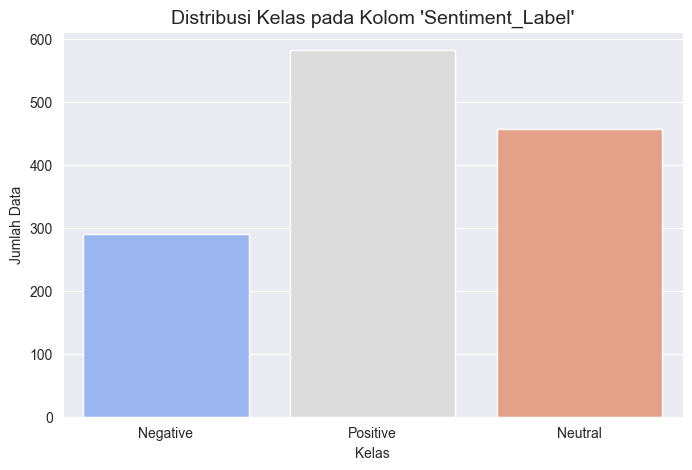

In [129]:
column_name = 'Sentiment_Label'

plt.figure(figsize=(8, 5))
sns.countplot(data=df, x=column_name, palette='coolwarm')

plt.title(f"Distribusi Kelas pada Kolom '{column_name}'", fontsize=14)
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.show()

### Ekstraksi Fitur

In [130]:
X = df['text_final']
y = df['Sentiment']

0 = Negative <br>
1 = Neutral <br>
2 = Positive

In [131]:
# Menggunakan metode BoW (Bag of Words)
bow = CountVectorizer()
X_bow = bow.fit_transform(X)

### Model Building

In [132]:
def eval_model_cv(model, X, y, cv_splits=5):
    cv = StratifiedKFold(n_splits=5, shuffle=True,random_state=42)

    y_pred = cross_val_predict(model, X, y, cv=cv)

    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='weighted')
    recall = recall_score(y, y_pred, average='weighted')
    f1 = f1_score(y, y_pred, average='weighted')

    # Print hasil
    print(f"========= Evaluasi Model ==========")
    print(f"Accuracy train: {accuracy:.4f}")
    print(f"Accuracy test: {accuracy}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1_Score: {f1:4f}")
    print("==================================================\n")

#### Random Forest

In [137]:
# BoW
rf = RandomForestClassifier(class_weight='balanced', random_state=42, n_estimators=100)
eval_model_cv(rf, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.7861
Accuracy test: 0.786144578313253
Precision: 0.8125
Recall: 0.7861
F1_Score: 0.783860



#### Decision Tree

In [138]:
dt = DecisionTreeClassifier(class_weight='balanced', random_state=42)
eval_model_cv(dt, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.7500
Accuracy test: 0.75
Precision: 0.7710
Recall: 0.7500
F1_Score: 0.747321



#### Logistic Regression

In [139]:
lr = LogisticRegression(class_weight='balanced', random_state=42)
eval_model_cv(lr, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.7741
Accuracy test: 0.7740963855421686
Precision: 0.7914
Recall: 0.7741
F1_Score: 0.771714



#### SVM

In [140]:
svm = SVC(class_weight='balanced', random_state=42)
eval_model_cv(svm, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.7101
Accuracy test: 0.7100903614457831
Precision: 0.7196
Recall: 0.7101
F1_Score: 0.704352



#### XGBoost

In [141]:
xgb = XGBClassifier(
    max_depth=5,
    learning_rate=0.3,
    n_estimators=100,
    objective='multi:softprob'
)

eval_model_cv(xgb, X_bow, y, cv_splits=5)

========= Evaluasi Model ==========
Accuracy train: 0.8102
Accuracy test: 0.8102409638554217
Precision: 0.8281
Recall: 0.8102
F1_Score: 0.808583



### WordCloud

In [147]:
# Fit model
xgb.fit(X_bow, y)

,objective,'multi:softprob'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


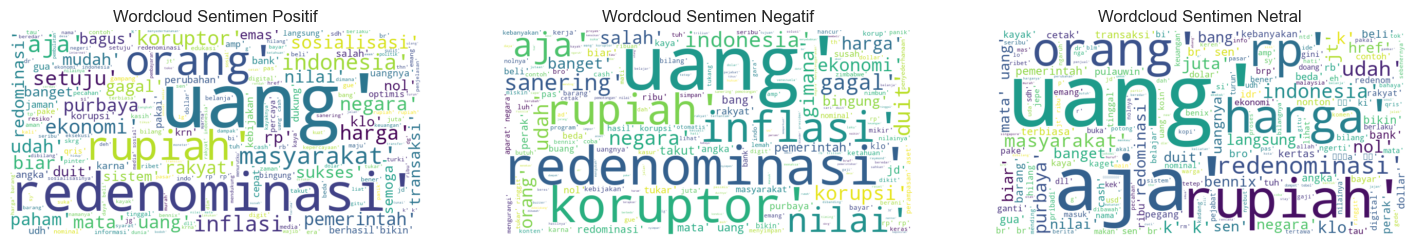

In [148]:
# Prediksi sentimen untuk seluruh komentar
X_new = bow.transform(X)
predictions = xgb.predict(X_new)

# Tambahkan prediksi ke dataframe
df['Predicted_Sentiment'] = predictions

# Pisahkan data berdasarkan prediksi sentimen
df_positive_pred = df[df['Predicted_Sentiment'] == 2]  # Sentimen positif
df_negative_pred = df[df['Predicted_Sentiment'] == 0]  # Sentimen negatif
df_neutral_pred = df[df['Predicted_Sentiment'] == 1]  # Sentimen netral

# Gabungkan semua komentar menjadi satu string
positive_text = " ".join(df_positive_pred['text_stopwords'].astype(str))
negative_text = " ".join(df_negative_pred['text_stopwords'].astype(str))
neutral_text = " ".join(df_neutral_pred['text_stopwords'].astype(str))

wordcloud_positive = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
wordcloud_negative = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
wordcloud_neutral = WordCloud(width=800, height=400, background_color='white').generate(neutral_text)

# Show
plt.figure(figsize=(18, 10))

plt.subplot(1, 3, 1)
plt.imshow(wordcloud_positive, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Positif")

plt.subplot(1, 3, 2)
plt.imshow(wordcloud_negative, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Negatif")

plt.subplot(1, 3, 3)
plt.imshow(wordcloud_neutral, interpolation='bilinear')
plt.axis("off")
plt.title("Wordcloud Sentimen Netral")

plt.show()